In [4]:
import os
import openai
import datetime
import pandas as pd
import json
import PyPDF2 as pdf
from PyPDF2 import PdfReader
import numpy as np
import time

In [5]:
file = open("Manuals/WLAN Manual/WLAN Manual.pdf","rb")
reader = PdfReader(file)
info = []
for i in range(0, len(reader.pages)):
    info.append(reader.pages[i].extract_text())
    info.append(" ")

In [7]:
api_key_file = open("OPENAI_API_KEY", "r")
openai.api_key = api_key_file.read()

In [8]:
info = np.array([[j for j in i] for i in info])
final_info = []
for i in info:
    for j in i: 
            final_info.append(j)
            
final_info = ''.join(final_info).replace('\n',' ')

/var/folders/9g/btnfbnzs5s98j60gmhcn4fnh0000gn/T/ipykernel_69343/221502225.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  info = np.array([[j for j in i] for i in info])


In [9]:
from IPython.display import Image, display

def show_relevant_image(img_src):
    display(Image(filename=img_src))

    return "Image Shown to User"

In [10]:
premise = "You’re an image and technical support bot that has access to manuals, and can make analysis and inferences to what may be helpful for a technical support person when they want to find a problem with the product, and point to relevant info. Some of the provided manuals have image sources, and you will always use the show_relevant_images function to show the images with anything you say if the explanation is at all related. If there is no relevant image, you will say say there is no relevant image. This means that you always use the show_relevant_image function to display the image when anything related to the image is mentioned by the user without asking the user if they want to see the image. This is very important, that the image is always shown without the user asking for it. Make sure to display images promptly in all responses. All of your information is based on the manuals. You can only refer to the manuals. Always link the source of the manuals. The manual information is here: "
premise = premise + final_info
messages=[
    {"role": "system", "content": premise}
      ]
functions=[{
                "name": "show_relevant_image",
                "description": "Always Run this function with the image sources. A function that displays an image to the user.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "img_src": {
                            "type": "string",
                            "description": "The source of the image that is to be displayed"
                        },
                    },
                    "required": ["img_src"],
                },
            }
]

def conversation(response):
    content = response + "Do this according to the manual. Show an image if there is one."
    messages.append({"role": "user", "content": content})
    
    completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions, function_call = "auto",
    )
    message = completion["choices"][0]["message"]
    

    if message.get("function_call"):
        function_name = message["function_call"]["name"]
        arguments = json.loads(message["function_call"]["arguments"])
        
        #Image Function
        if function_name == "show_relevant_image":
            function_response = show_relevant_image(arguments['img_src'])
            
        else:
            raise NotImplementedError()
        
        messages.append({"role":"function","name":function_name,"content":function_response})
        second_response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0613",
            messages = messages,
        )
        answer_response = second_response.choices[0]["message"]["content"].strip()
        messages.append({"role": "assistant", "content": answer_response})
    
    
    #Normal Block
    else:
        chat_response = completion.choices[0].message.content
        messages.append({"role": "assistant", "content": chat_response})
    
    for i in messages:
        if i['role'] == "user":
            print("User: ", i['content'][0:-63])
            #print("\n")
        elif i['role'] == "assistant":
            print("ChatGPT: ", i['content'])
        print("\n")
    time.sleep(15)
    

In [148]:
len("")

63

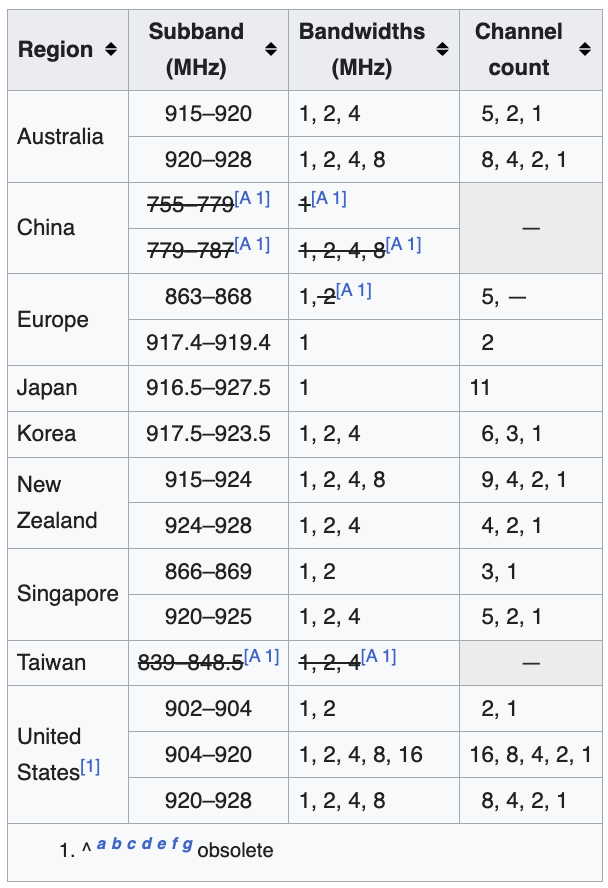



User:  Tell me about 3.65GHz




ChatGPT:  The 3.65 GHz band, also known as 802.11y, is a frequency range designated for wireless LAN (WLAN) use. This band is primarily used in the United States. In the original specification, it was only allowed as a licensed band. However, under newer frequency allocations from the FCC, it falls under the 3.55–3.7 GHz Citizens Broadband Radio Service band, allowing for unlicensed use under certain rules.

According to Annex J of IEEE 802.11y-2008, the 3.65 GHz band provides a 40 MHz bandwidth, which can be divided into different channel configurations. It can be divided into eight 5 MHz channels, four 10 MHz channels, or two 20 MHz channels. 

Please note that the use of the 3.65 GHz band should adhere to specific technical requirements and regulations specified by local authorities and the FCC.

Image source: Manuals/WLAN Manual/WLAN Images/Image_802.11y_file.png


User:  Tell me about 2.4GHz




ChatGPT:  The 2.4 GHz band, also known as 802.11b/g

In [14]:
conversation("How about that it is related to 802.11? Shouldn't you show an image of that too")